<a href="https://colab.research.google.com/github/alexiamhe93/RedditRepairInitiations/blob/main/S3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S3 - Notebook for replicating results

This notebook contains the code for replicating the findings from the article titled:

"Repairs are universal but not inevitable: Reddit dialogues usually end before misunderstandings can be resolved".



# 1. Initiate notebook

This section is required for the notebook to run. It install and loads all necessary packages (including installing R studio), as well as download and load the data.

We recommend running this notebook in Google Colab as it is designed for easy replication (load in Colab - click runtime and "run all"). For an easy accessible version, click here and go to "S3":

https://github.com/alexiamhe93/RedditRepairInitiations

## 1.1 Install packages

This installs R and the necessary R packages for running the mixed effects model.

WARNING - this can take significant time (aprox. 30 minutes).

In [ ]:
# Install R and Rpy2
!apt-get install r-base
!pip install -q rpy2
packnames = ('lme4', "AICcmodavg","sjPlot", "MuMIn")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

In [14]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("glmmTMB", type="source")
install.packages("DHARMa", type="source")

We also install the [lifelines](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html) package required for the survival analysis.

In [ ]:
!pip install lifelines

## 1.2 Load packages

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
# Plotting
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
from itertools import combinations
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import chisquare
from sklearn.preprocessing import StandardScaler

In [17]:
# For the survival analysis
from lifelines import KaplanMeierFitter,CoxPHFitter,WeibullAFTFitter,AalenAdditiveFitter
from lifelines.statistics import logrank_test
from lifelines import WeibullFitter, ExponentialFitter,LogNormalFitter, LogLogisticFitter
from lifelines import NelsonAalenFitter,PiecewiseExponentialFitter,GeneralizedGammaFitter,SplineFitter
from lifelines.utils import k_fold_cross_validation
from lifelines.plotting import qq_plot
import math

## 1.3 Download and load data

In [2]:
# for downloading data
import requests, zipfile, io
r = requests.get('https://github.com/alexiamhe93/RedditRepairInitiations/blob/main/data.zip?raw=true' )
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [3]:
# Load data
try:
  # Turn level data
  turn_df = pd.read_csv("turn_df.csv")
  # Dialogue level data
  surv_df = pd.read_csv("surv_df.csv")
except:
  turn_df = pd.read_csv("Data/turn_df.csv")
  surv_df = pd.read_csv("Data/surv_df.csv")

## 1.4 Load functions

In [24]:
# Plotting functions

def create_subplot_grid(data, columns, target_column, switch_axes=False):
    """
    Create a gridded subplot for a DataFrame with specified target column and multiple feature columns.
    """
    num_subplots = len(columns)
    fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))

    for i, column in enumerate(columns):
        x_values = data[column] if not switch_axes else data[target_column]
        y_values = data[target_column] if not switch_axes else data[column]

        ax = axes[i] if num_subplots > 1 else axes
        ax.scatter(x_values, y_values, label=f'{column} vs {target_column}')
        ax.set_xlabel(column if not switch_axes else target_column)
        ax.set_ylabel(target_column if not switch_axes else column)
        ax.legend()

    plt.tight_layout()
    plt.show()

def create_histogram_subplot_grid(data, columns, bins=10):
    """
    Create a gridded subplot with histograms for specified columns in a DataFrame.
    """
    num_subplots = len(columns)
    fig, axes = plt.subplots(nrows=1, ncols=num_subplots, figsize=(15, 5))

    for i, column in enumerate(columns):
        ax = axes[i] if num_subplots > 1 else axes
        ax.hist(data[column], bins=bins, edgecolor='black')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def create_grouped_histograms_plotly(data, x, group):
    """
    Create grouped histograms using Plotly for a DataFrame with a specified variable and grouping column.
    """
    fig = px.histogram(data, x=x, color=group, marginal="rug", facet_col=group)
    fig.show()
def plot_dataframe(df):
    """
    For plotting subreddits
    """
    melted_df = df.melt(id_vars='sub', var_name='category', value_name='value')
    fig = px.bar(melted_df, x='sub', y='value', color='category',
                 labels={'value': 'Value', 'sub': 'Sub', 'category': 'Category'},barmode="group")
    fig.update_layout(height=500, width=800)
    fig.show()
# Chi Square test
def calculate_Chi2_categories(df, target_col, null_reject = 0.05):
  """
  Function for calculating whether there is a statistically significant difference in variable categories.
  """
  observed_frequencies = df[target_col].value_counts()
  expected_frequency = len(df) / len(observed_frequencies)
  chi2, p = chisquare(observed_frequencies)
  print(f"Chi-square statistic: {chi2:.2f}")
  print(f"P-value: {p:.6f}")
  alpha = 0.05
  if p < alpha:
      print("\nReject the null hypothesis: There are significant differences in the frequencies.")
  else:
      print("\nFail to reject the null hypothesis: There are no significant differences in the frequencies.")

# Lifelines survival analysis functions

def fit_and_score_features2(X, event_col="status",time_ = "time"):
  """
  Get the feature scores for model selection:
  Adapted from: https://stackoverflow.com/questions/53467348/feature-covariates-selection-in-coxphfitter-lifelines-survival-analysis
  """
  y=X[[time_,status]]
  X.drop([time_, status], axis=1, inplace=True)
  n_features = X.shape[1]
  scores = np.empty(n_features)
  m = CoxPHFitter()
  for j in range(n_features):
      Xj = X.iloc[:, j:j+1]
      Xj=pd.merge(Xj, y,  how='right', left_index=True, right_index=True)
      m.fit(Xj, duration_col=time_, event_col=event_col, show_progress=True)
      scores[j] = m.score(Xj) #,scoring_method='concordance_index') # Currently calculating loglikelihood
  return scores

# For Lifelines model fit.

def partial_AIC_(df,model_names, models):
  """
  Fetches the Partial AIC for comparing model performance.
  """
  assumptions = []
  AIC_list = []
  for i in range(0,len(models)):
    try:
      AIC_list.append(models[i].AIC_partial_)
    except:
      AIC_list.append(0)
  AIC_df =pd.DataFrame({"Model":model_names, "Partial AIC":AIC_list})
  AIC_df = AIC_df.sort_values("Partial AIC").round(3)
  return AIC_df

def AIC_BIC(df,model_names, models):
  """
  Fetches the AIC and BIC for comparing model performance.
  """
  assumptions = []
  AIC_list = []
  BIC_list = []
  for i in range(0,len(models)):
    try:
      AIC_list.append(models[i].AIC_)
      BIC_list.append(models[i].BIC_)
    except:
      AIC_list.append(0)
      BIC_list.append(9)
  AIC_df =pd.DataFrame({"Model":model_names, "AIC":AIC_list, "BIC":BIC_list})
  AIC_df = AIC_df.sort_values("AIC").round(3)
  return AIC_df


def convertHazard_to_density(cum_hazard, return_survival=False):
  """
  Calculates the cumulative density from the cumulative hazard (e^(-Hazard))
  """
  survival = math.exp(-cum_hazard)
  if return_survival:
    return survival
  else:
    return 1 - survival

def get_cumulative_density(model, max_time = 36, return_survival=False):
  """
  Iterate over time points and calculate cumulative density
  """
  times = list(range(1,max_time))
  dens_lst = []
  for t in times:
    cum_hazard = model.cumulative_hazard_at_times(t)
    dens_ = convertHazard_to_density(cum_hazard, return_survival)
    dens_lst.append(dens_)
  return pd.DataFrame({"Time":times,"Cumulative density":dens_lst})


# 2. Descriptive statistics


In [19]:
print(f"There are {len(turn_df)} turns in the dataset, sampled from {len(surv_df)} threads, belonging to {len(surv_df.id_conv.unique())} posts.")
dia_len_desc = surv_df.dia_len.describe()
dL_m = dia_len_desc.loc["mean"]
dL_median = dia_len_desc.loc["50%"]
dL_std = dia_len_desc.loc["std"]
dL_max = dia_len_desc.loc["max"]
print(f"On average, conversations are {dL_median} turns in length. The distribution of dialogue length is highly skewed (M={dL_m:.2f}; SD={dL_std:.2f}; Min = 1; Max = {dL_max})")
CR_turn_desc = turn_df.CR_num.describe()
CRt_pct = CR_turn_desc.loc["mean"] * 100
nCR = turn_df.CR_num.sum()
nT_CR = len(turn_df) / nCR
print(f"There is a repair initiation approximately once every {nT_CR:.0f} turns (n={nCR}; {CRt_pct:.2f}%).")
CR_dia_desc = surv_df.CR.describe()
CRd_pct = CR_dia_desc.loc["mean"] * 100
nCRd = surv_df.CR.sum()
nD_CR = len(surv_df) / nCRd
print(f"On average, one in every {nD_CR:.0f} dialogues contain a repair (n={nCRd}; {CRd_pct:.2f}%).")

There are 35745 turns in the dataset, sampled from 13290 threads, belonging to 7445 posts.
On average, conversations are 2.0 turns in length. The distribution of dialogue length is highly skewed (M=2.69; SD=1.43; Min = 1; Max = 11.0)
There is a repair initiation approximately once every 11 turns (n=3109; 8.70%).
On average, one in every 5 dialogues contain a repair (n=2556; 19.23%).


Using the validation data (n = 1891 turns), the graph shows the frequency of initiation types (see [Dingemanse et al., 2015](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0136100)).

In [20]:
vTurn_df = turn_df[turn_df.validation == True]
CR_df = vTurn_df[vTurn_df["CR_type"]!= "_none_"]
CR_counts = CR_df["CR_type"].value_counts().reset_index()
CR_counts.columns = ["Category", "Count"]
CR_counts["Repair type"] = "Other initiated"
CR_counts = CR_counts.sort_values("Count")

fig = px.bar(CR_counts, x="Category", y="Count", barmode="group")
fig.update_layout(height=500, width=800,showlegend=False,xaxis=dict(tickmode='linear'))
fig.update_layout(xaxis_title=f'Initiation type, total = {len(CR_df)}', yaxis_title="Count")
# Show the plot
fig.show()

This graph shows the average dialogue length across different subreddits.

In [25]:
plot_dataframe(surv_df.groupby("sub").agg({"dia_len":"mean"}).reset_index().sort_values("dia_len"))

This graph shows the proportion of repairs across subreddits.

In [55]:
# Data for subplot 1
sub_df2 = surv_df.groupby('sub')['CR'].agg("mean").reset_index()
sub_df2.columns = ["Subreddit", "Repair"]
sub_df2["No Repair"] = 1 - sub_df2["Repair"]
sub_df2 = sub_df2.sort_values("Repair")

# Data for subplot 2
sub_df3 = turn_df.groupby('sub')['CR_num'].agg("mean").reset_index()
sub_df3.columns = ["Subreddit", "Repair"]
sub_df3["No Repair"] = 1 - sub_df3["Repair"]
sub_df3 = sub_df3.sort_values("Repair")

# Create subplots
fig = make_subplots(rows=1, cols=2)

# Add traces for subplot 1
bar_trace1 = px.bar(sub_df2, x=["Repair", "No Repair"], y="Subreddit").data
for trace in bar_trace1:
    fig.add_trace(trace, row=1, col=1)

# Add traces for subplot 2
bar_trace2 = px.bar(sub_df3, x=["Repair", "No Repair"], y="Subreddit").data
for trace in bar_trace2:
    fig.add_trace(trace, row=1, col=2)

# Update layout
#fig.update_layout(height=800, width=1000, showlegend=True)
fig.update_layout(height=800, width=1000, showlegend=True)
fig.update_layout(barmode="relative")

# For subplot 1, remove the legend
fig.update_traces(showlegend=False, row=1, col=1)
fig.update_yaxes(showticklabels=False, row=1, col=2)


# Update x-axis titles
fig.update_xaxes(title_text='Proportion of dialogues with repair', row=1, col=1)
fig.update_xaxes(title_text='Proportion of turns with repair', row=1, col=2)

# Show plot
fig.show()

This graph shows the proportion of repair initiations at each turn.

In [27]:

CRdf_NR = surv_df[surv_df.CR ==0]
CRdf_R = surv_df[surv_df.CR !=0]
CRdf_R["Repair"] = "Yes"
CRdf_NR["Repair"] = "No"
CRdf_R["Repair_bin"] = CRdf_R.Repair.replace({"Yes":1,"No":0})
CRdf_NR["Repair_bin"] = CRdf_NR.Repair.replace({"Yes":1,"No":0})
ResR =  CRdf_R.groupby('dia_len')['Repair_bin'].agg(['sum']).reset_index()
ResNoR =  CRdf_NR.groupby('dia_len')['Repair_bin'].agg(['count']).reset_index()
ResR = ResR.rename(columns = {"sum": "count"})
ResR["Repair"] = "Yes"
ResNoR["Repair"] = "No"
res_allR = pd.concat([ResR, ResNoR])
res_allR = res_allR.rename(columns = {"dia_len":"Dialogue Length","count":"Dialogue count"})
res_allR["Log(Dialogue count)"] = np.log(res_allR["Dialogue count"])

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1) # change nrows to 3 if want the other plot

colors = px.colors.qualitative.Set1  # You can replace this with any color palette you prefer

for i, (repair_type, group_df) in enumerate(res_allR.groupby('Repair')):
    fig.add_trace(
        go.Bar(
            x=group_df['Dialogue Length'],
            y=group_df['Dialogue count'],
            name=repair_type,
            marker_color=colors[i % len(colors)]  # Ensure the color is consistent
        ),
        row=1, col=1
    )

for i, (repair_type, group_df) in enumerate(res_allR.groupby('Repair')):
    fig.add_trace(
        go.Bar(
            x=group_df['Dialogue Length'],
            y=group_df['Log(Dialogue count)'],
            showlegend = False,
            marker_color=colors[i % len(colors)]  # Ensure the color is consistent
        ),
        row=2, col=1
    )
fig.update_layout(
    barmode='group',
    xaxis_title='Dialogue Length',
    title_text='',
    width = 1000,
    height = 600,
    legend_title_text='Contains repair initiation',
)

fig.update_xaxes(tickmode='array', tickvals=res_allR['Dialogue Length'].unique(), row=1, col=1)
fig.update_xaxes(tickmode='array', tickvals=res_allR['Dialogue Length'].unique(), row=2, col=1)
fig.update_xaxes(tickmode='array', tickvals=res_allR['Dialogue Length'].unique(), row=3, col=1)


fig.update_yaxes(title_text='Dialogue count', row=1, col=1)
fig.update_yaxes(title_text='Log dialogue count', row=2, col=1)
fig.update_yaxes(title_text='Log Centered dialogue count', row=3, col=1)
fig.update_xaxes(title_text='Dialogue Length (turns)', row=3, col=1)


fig.show()


In [51]:
res_allR

,Dialogue Length,Dialogue count,Repair,Log(Dialogue count)
0,2,642,Yes,6.464588
1,3,694,Yes,6.542472
2,4,492,Yes,6.198479
3,5,268,Yes,5.590987
4,6,170,Yes,5.135798
5,7,106,Yes,4.663439
6,8,84,Yes,4.430817
7,9,35,Yes,3.555348
8,10,23,Yes,3.135494
9,11,42,Yes,3.737670


# 3. Analysis 1: Mixed effects model

In this section, we build a mixed effects model to explore the frequency of repairs across subreddits. We first perform model selection before running the final model and checking assumptions have been met.

Load necessary R packages.

In [28]:
%%R
# For running the generalized mixed effects model
library(lme4)
# For comparing models
library(AICcmodavg)
# For plotting residuals (assumptions)
library(sjPlot)
# For estimating the explained variance R^2
library(MuMIn)


Attaching package: ‘AICcmodavg’



    checkConv



Attaching package: ‘MuMIn’



    AICc, DIC, importance




Load the data into R.

In [29]:
mme_df = turn_df
response = "CR_num"
fixed_effects = ["turn","wc","neg","neu","pos"]
random_effects = ["id_thread", "id_aut", "id_conv","sub"]
mme_cols = [response] + fixed_effects + random_effects
mme_df = mme_df[mme_cols]
# rename columns for simplicity
mme_df = mme_df.rename(columns = {"CR_num":"CR","turn":"t","id_aut":"aut","id_thread":"thread","id_conv":"conv"})
# Log center the wordcount to scale the variable
scaler = StandardScaler()
mme_df["log_wc"] = np.log(mme_df.wc)
mme_df["log_wc"] = mme_df.log_wc.mean() - mme_df.log_wc
mme_df.head()

,CR,t,wc,neg,neu,pos,thread,aut,conv,sub,log_wc
0,0,3,216,0.963591,0.033465,0.002945,thread_0,aut_0,conv_0,politics,-2.773944
1,0,2,176,0.148028,0.805765,0.046207,thread_1,aut_1,conv_1,explainlikeimfive,-2.569149
2,1,2,260,0.514253,0.454226,0.031521,thread_2,aut_2,conv_2,changemyview,-2.959347
3,0,5,11,0.001740,0.005990,0.992270,thread_3,aut_3,conv_3,explainlikeimfive,0.203439
4,0,2,13,0.776134,0.217197,0.006670,thread_4,aut_4,conv_4,funny,0.036385


In [30]:
%%R -i mme_df
data <- mme_df

/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



## 3.1 Model selection.

We first select the best intercept model using AIC. The intercept models use either "subreddit", "conversation" or "thread" as random effects. We model them as random effects due to their hierarchical relations to one another: threads belong to conversations belong to threads.

In [31]:
%%R
f_i0 <- "CR ~ 1 + (1|sub)"
f_i1 <- "CR ~ 1 + (1|sub) + (1|conv)"
f_i2 <- "CR ~ 1 + (1|sub) + (1|thread)"
f_i3 <- "CR ~ 1 + (1|sub) + (1|conv) + (1|thread)"
# Run models
im0 <- glmer(f_i0, data = data, family="binomial")
im1 <- glmer(f_i1, data = data, family="binomial")
im2 <- glmer(f_i2, data = data, family="binomial")
im3 <- glmer(f_i3, data = data, family="binomial", glmerControl(optCtrl=list(maxfun=100000))) # No convergence
# We remove im3 as the matrix has a singular fit (likely too complex)
model_lst = list(im0,im1,im2)
mod_names = c(f_i0,f_i1,f_i2)
myaicc<-as.data.frame(AICcmodavg::aictab(cand.set= model_lst, modnames=mod_names))[,-c(5,7)]
myaicc$eratio<-max(myaicc$AICcWt)/myaicc$AICcWt
out <- data.frame(Model=myaicc[,1],round(myaicc[, 2:7],4))
out

                          Model K     AICc Delta_AICc AICcWt Cum.Wt    eratio
2   CR ~ 1 + (1|sub) + (1|conv) 3 20480.63     0.0000 0.9998 0.9998     1.000
1              CR ~ 1 + (1|sub) 2 20497.87    17.2429 0.0002 0.9999  5549.467
3 CR ~ 1 + (1|sub) + (1|thread) 3 20499.79    19.1632 0.0001 1.0000 14495.554


The best model has conversation and subreddits as random slopes. We can also use an ANOVA to compare the two best models:

In [32]:
%%R
anova(im0,im1)

Data: data
Models:
im0: CR ~ 1 + (1 | sub)
im1: CR ~ 1 + (1 | sub) + (1 | conv)
    npar   AIC   BIC logLik deviance  Chisq Df Pr(>Chisq)    
im0    2 20498 20515 -10247    20494                         
im1    3 20481 20506 -10237    20475 19.243  1  1.151e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


We now use a backwards selection process to determine how the substraction of covariates affect the final model.

We add in time, the log word count, negative and positive sentiment, and an interaction between these last two variables.

In [33]:
%%R
# Define maximal model and become increasingly more simple. We assume an interaction between negative and positive sentiment (as they are from the same classifier)
# Dropped neutral as the model matrix is rank deficient
f_mx1 = "CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1|conv) + (1|sub)"
f_mx2 = "CR ~ 1 + t + log_wc + neg + pos + (1|conv) + (1|sub)"
f_mx3 = "CR ~ 1 + t + log_wc + (1|conv) + (1|sub)"
f_mx4 = "CR ~ 1 + t + (1|conv) + (1|sub)"
mx_1 = glmer(f_mx1, data = data, family="binomial")
mx_2 = glmer(f_mx2, data = data, family="binomial")
mx_3 = glmer(f_mx3, data = data, family="binomial")
mx_4 = glmer(f_mx4, data = data, family="binomial")
model_lst = list(im1,mx_1,mx_2,mx_3,mx_4)
mod_names = c("intercept","max (all)","max (no interaction)","no sentiment","turn only")
myaicc<-as.data.frame(AICcmodavg::aictab(cand.set= model_lst, modnames=mod_names))[,-c(5,7)]
myaicc$eratio<-max(myaicc$AICcWt)/myaicc$AICcWt
out <- data.frame(Model=myaicc[,1],round(myaicc[, 2:7],4))
out

                 Model K     AICc Delta_AICc AICcWt Cum.Wt        eratio
2            max (all) 8 19314.82     0.0000      1      1  1.000000e+00
3 max (no interaction) 7 19368.80    53.9739      0      1  5.251429e+11
4         no sentiment 5 20015.04   700.2132      0      1 1.120394e+152
5            turn only 4 20050.20   735.3748      0      1 4.837328e+159
1            intercept 3 20480.63  1165.8029      0      1 1.415407e+253


The more complex model is the best model. We can compare it using an ANOVA against the intercept model and the model with no interactions (second best).

In [34]:
%%R
# Comparing with intercept
anova(im3,mx_1)

Data: data
Models:
im3: CR ~ 1 + (1 | sub) + (1 | conv) + (1 | thread)
mx_1: CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1 | conv) + (1 | sub)
     npar   AIC   BIC   logLik deviance  Chisq Df Pr(>Chisq)    
im3     4 20483 20517 -10237.3    20475                         
mx_1    8 19315 19383  -9649.4    19299 1175.8  4  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [35]:
%%R
# Comparing with second best model
anova(mx_1,mx_2)

Data: data
Models:
mx_2: CR ~ 1 + t + log_wc + neg + pos + (1 | conv) + (1 | sub)
mx_1: CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1 | conv) + (1 | sub)
     npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
mx_2    7 19369 19428 -9677.4    19355                         
mx_1    8 19315 19383 -9649.4    19299 55.975  1  7.341e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Now we add in random slopes as, without, we risk more type 1 errors.

WARNING: These models take significant time to run (aprox. 20 minutes).

In [36]:
%%R
# random slopes in conversation random effect
f_rs1 = "CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1 + t + log_wc |conv) + (1|sub)"
f_rs2 = "CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1 + t |conv) + (1|sub)"
f_rs3 = "CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1 + log_wc |conv) + (1|sub)"
m_rs1 = glmer(f_rs1, data = data, family="binomial") # No convergence
m_rs2 = glmer(f_rs2, data = data, family="binomial") # No convergence
m_rs3 = glmer(f_rs3, data = data, family="binomial")

In [37]:
%%R
# random slopes in subreddit random effect
f_rss1 = "CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1|conv) + (1 + t + log_wc |sub)"
f_rss2 = "CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1|conv) + (1 + t |sub)"
f_rss3 = "CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1|conv) + (1 + log_wc|sub)"
m_rss1 = glmer(f_rss1, data = data, family="binomial") # no convergence
m_rss2 = glmer(f_rss2, data = data, family="binomial") # no convergence
m_rss3 = glmer(f_rss3, data = data, family="binomial")

Only the log_wc slope model converges - let's use an anova to see how it performs against the other maximal model.

In [38]:
%%R
anova(mx_1, m_rss3)

Data: data
Models:
mx_1: CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1 | conv) + (1 | sub)
m_rss3: CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1 | conv) + (1 + log_wc | sub)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
mx_1      8 19315 19383 -9649.4    19299                         
m_rss3   10 19302 19387 -9641.1    19282 16.567  2  0.0002526 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


We can see that the models are only very slightly different to one another, however we still keep the more complex model.

## 3.2 Analysis 1 results

In [39]:
%%R
summary(m_rss3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: CR ~ 1 + t + log_wc + neg + pos + neg:pos + (1 | conv) + (1 +  
    log_wc | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 19302.3  19387.1  -9641.1  19282.3    35735 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5458 -0.3291 -0.2636 -0.1703 24.5310 

Random effects:
 Groups Name        Variance Std.Dev. Corr
 conv   (Intercept) 0.07913  0.2813       
 sub    (Intercept) 0.13420  0.3663       
        log_wc      0.01379  0.1175   0.08
Number of obs: 35745, groups:  conv, 7445; sub, 27

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.48847    0.08473 -29.371  < 2e-16 ***
t             0.25210    0.01147  21.989  < 2e-16 ***
log_wc        0.10703    0.03087   3.467 0.000526 ***
neg          -0.16250    0.06289  -2.584 0.009767 ** 
pos          -2.15330    0.10740 -20.049  < 2e-16 *

Calculate the odds ratios for the fixed effects.

In [40]:
%%R
se <- sqrt(diag(vcov(m_rss3)))
# table of estimates with 95% CI
tab <- cbind(Est = fixef(m_rss3), LL = fixef(m_rss3) - 1.96 * se, UL = fixef(m_rss3) + 1.96 * se)
odds_ratio = exp(tab)
probabilities = odds_ratio/(1+odds_ratio)
round(odds_ratio,2)

             Est   LL   UL
(Intercept) 0.08 0.07 0.10
t           1.29 1.26 1.32
log_wc      1.11 1.05 1.18
neg         0.85 0.75 0.96
pos         0.12 0.09 0.14
neg:pos     0.00 0.00 0.00


In [50]:
# Run this if you want to export an easily interpreted tabular output of the model
# It provides the variance and ICC.
%%R
tab_model(m_rss3, file = "final_model_v5_RS1.html")

Calculate the estimated probabilities of repair for each of the subreddits (see [Dingemanse et al., 2015](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0136100)).

In [43]:
%%R -o sub_random_effects,con_random_effects,intercept

fixed_effects = fixef(m_rss3)
intercept <- fixed_effects["(Intercept)"]
random_effects <- ranef(m_rss3)
sub_random_effects = random_effects$sub
con_random_effects = random_effects$conv

In [44]:
con_random_effects = con_random_effects.reset_index().rename(columns={"index":"conversation"})
sub_random_effects = sub_random_effects.reset_index().rename(columns={"index":"subreddit"})
sub_weights = mme_df['sub'].value_counts().reset_index().rename(columns={"index":"subreddit","sub":"count"})
sub_df5 = mme_df.groupby('sub')['CR'].agg("mean").reset_index()
sub_proportions = sub_df5[["sub","CR"]].rename(columns={"sub":"subreddit","CR":"Raw Probability"})
sub_all = pd.merge(sub_random_effects, sub_weights, on='subreddit', how='inner')
sub_all = pd.merge(sub_all, sub_proportions, on='subreddit', how='inner')
# Replicating Dingemanse and colleagues probabilities
intercept = intercept[0]
m_intercept_sub = sub_all["(Intercept)"].mean()
m_Wintercept_sub = np.average(sub_all["(Intercept)"], weights=sub_all["count"])
m_intercept_con = con_random_effects["(Intercept)"].mean()
sub_all["Probability"] = sub_all["(Intercept)"] + intercept + m_intercept_sub + m_Wintercept_sub + m_intercept_con
sub_all["Estimated Probability"] =  1 / (1 + np.exp(-sub_all["Probability"]))
sub_all[["subreddit","Estimated Probability", "Raw Probability"]].round(2).sort_values("Estimated Probability", ascending = False)

,subreddit,Estimated Probability,Raw Probability
10,IAmA,0.23,0.25
5,changemyview,0.10,0.17
20,science,0.10,0.12
17,psychology,0.10,0.11
3,books,0.09,0.07
7,explainlikeimfive,0.09,0.12
8,food,0.09,0.10
1,askthe,0.09,0.10
15,pics,0.09,0.10
26,worldnews,0.08,0.12


Check the correlation between estimated and raw probabilities (proportion of repairs in a subreddit).

In [45]:
from scipy.stats import pearsonr

# Assuming sub_all is your DataFrame
correlation, p_value = pearsonr(sub_all["Estimated Probability"], sub_all["Raw Probability"])

print(f"Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

Correlation: 0.89
P-value: 0.0000


## 3.3 Check assumptions

In [46]:
# Load libraries for assumption checks
%%R
library(glmmTMB)
library(DHARMa)

Plot random effect quartiles against standardized normal quartiles.

`geom_smooth()` using formula = 'y ~ x'


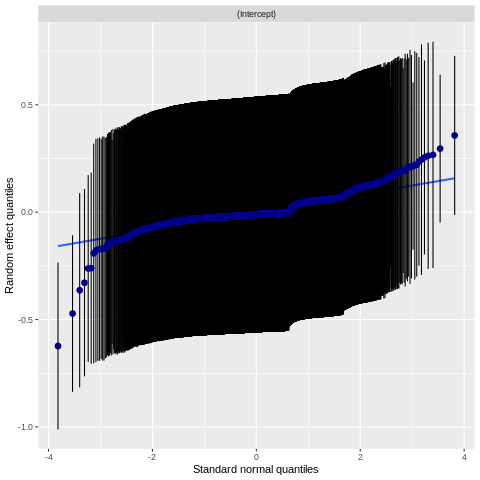

In [47]:
%%R
x = plot_model(m_rss3, grid=T, type="diag")
x[[1]]

`geom_smooth()` using formula = 'y ~ x'


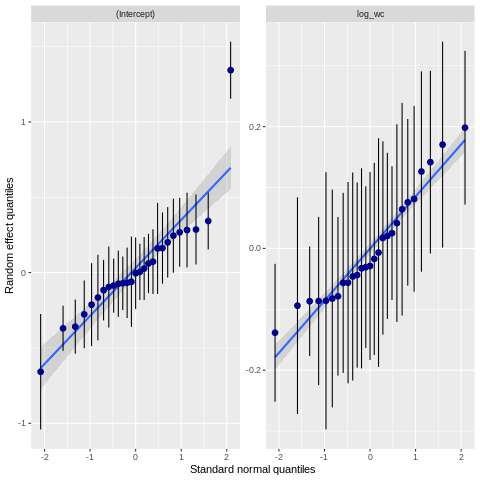

In [48]:
%%R
x[[2]]

Use simulated residuals to check assumptions using [DHARMa package](https://cran.r-project.org/web/packages/DHARMa/vignettes/DHARMa.html).

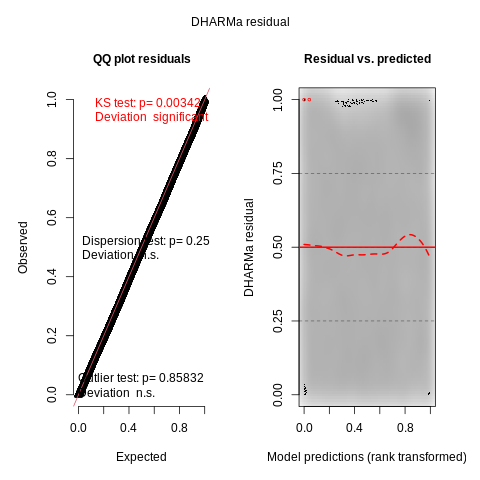

In [49]:
%%R
simulationOutput <- simulateResiduals(fittedModel = m_rss3)
plot(simulationOutput)

While the KS-test indicates residuals deviate from the expected distribution, visual observation and the remaining statistics indicate that the model generally meets the assumptions.

# 4. Analysis 2: Survival Analysis

## 4.1 Cumulative density for time-to-repair (Kaplan Meier).

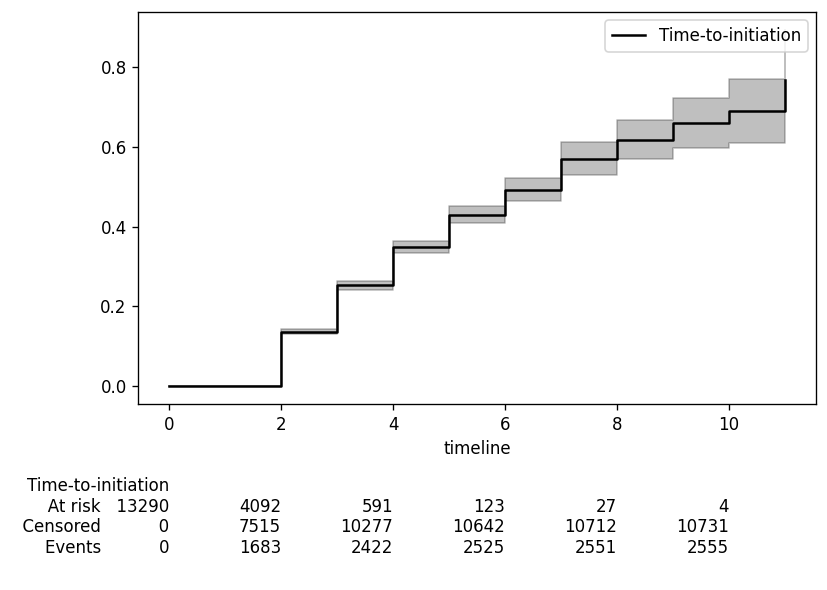

In [ ]:
baseline_T = surv_df.timeToCR
baseline_E = surv_df.CR
kmf = KaplanMeierFitter()
ax = None  # Initialize ax
plt.figure(figsize=(7, 5))
kmf.fit(baseline_T, baseline_E, label = "Time-to-initiation")
kmf.plot_cumulative_density(ax=ax, color="black", at_risk_counts = True, loc = slice(0,11))
plt.tight_layout()

This shows the cumulative density values at each turn with confidence intervals.

In [ ]:
Cum_density = kmf.confidence_interval_cumulative_density_
Cum_density.columns = ["CI Low 95%","CI High 95%"]
Cum_density["Cumulative density"] = kmf.cumulative_density_["Time-to-initiation"]
Cum_density = Cum_density[["Cumulative density", "CI Low 95%","CI High 95%"]]
Cum_density.round(2)

,Cumulative density,CI Low 95%,CI High 95%
0.0,0.00,0.00,0.00
1.0,0.00,0.00,0.00
2.0,0.14,0.13,0.14
3.0,0.25,0.24,0.26
4.0,0.35,0.33,0.36
5.0,0.43,0.41,0.45
6.0,0.49,0.46,0.52
7.0,0.57,0.53,0.61
8.0,0.62,0.57,0.67
9.0,0.66,0.60,0.72


The median survival time is the last time point where 50% of dialogues have not yet experienced repair.

In [ ]:
average_time_until_repair = kmf.median_survival_time_ + 1
print(f"Median time until a repair: {average_time_until_repair}")

Median time until a repair: 8.0


## 4.2 Cumulative hazards

To be able to make predictions about the time-to-repair we may use parametric models and cumulative hazards. Here, we fit different parametric estimators from the Lifelines package to determine the best fit.


,Fitter,AIC,BIC
0,Weibull,15067.09,15082.08
1,LogNormal,13961.43,13976.42
2,LogLogistic,14434.86,14449.85
3,Exponential,18070.13,18077.62


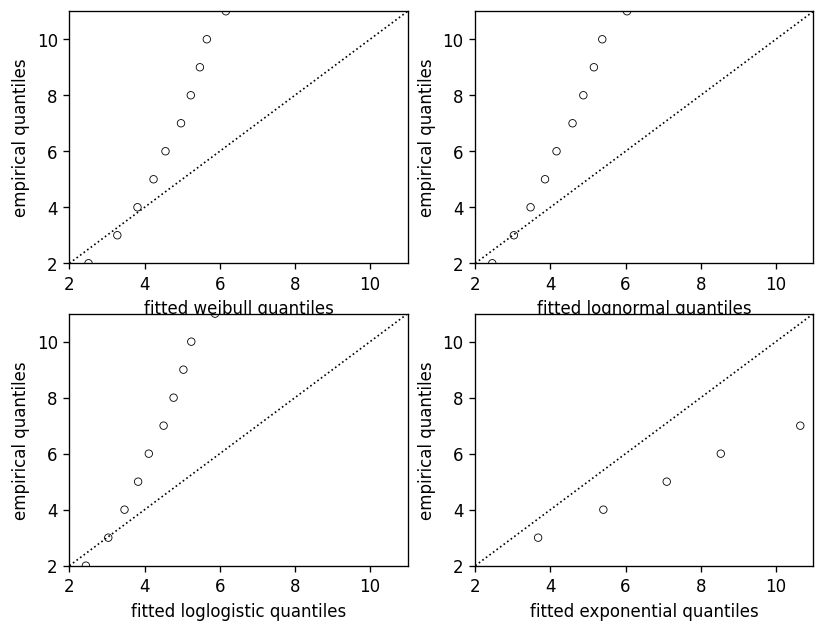

In [ ]:
# Parametric models
T = baseline_T
E = baseline_E

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)
AIC_ = []
BIC_ = []
Names_ = ["Weibull","LogNormal","LogLogistic","Exponential"]
for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(T, E)
    qq_plot(model, ax=axes[i])
    AIC_.append(model.AIC_)
    BIC_.append(model.BIC_)
AICs = pd.DataFrame({"Fitter":Names_,"AIC":AIC_,"BIC":BIC_}).round(2)
AICs

On visual inspection, we observe that the exponential model appears to have the best fit. We can use a built in function from Lifelines to try all the parametric models and select the best one.

In [ ]:
from lifelines.utils import find_best_parametric_model
best_model, best_aic_ = find_best_parametric_model(T, E, scoring_method="AIC")
print(best_model)

<lifelines.PiecewiseExponentialFitter:"PiecewiseExponentialFitter: 3 breakpoint", fitted with 13290 total observations, 10734 right-censored observations>


The recommended model is a piecewise exponential with three breakpoints (i.e., three places where the slope can change in the graph). We use only one breakpoint as the data has only 11 time points. The below plot shows the non-parametric Nelson Aalen cumulative hazards, the exponential estimated hazards, and the Piecewise Exponential hazards.

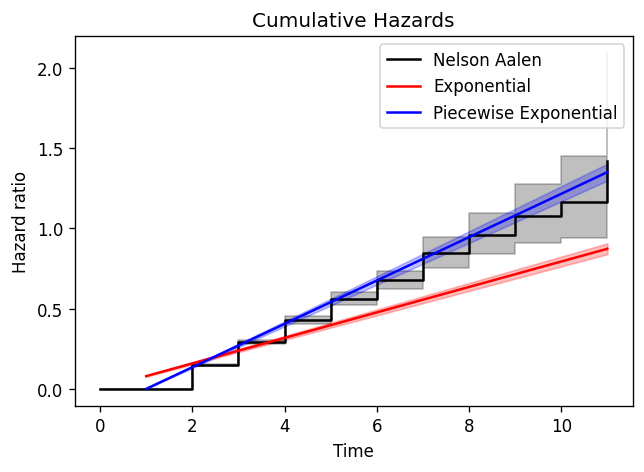

In [ ]:
naf = NelsonAalenFitter()
exp = ExponentialFitter()
exp2 = PiecewiseExponentialFitter(breakpoints =[1])
ax = None  # Initialize axe
plt.figure(figsize=(6, 4))

naf.fit(baseline_T, baseline_E, label = "Nelson Aalen")
naf.plot(ax=ax, loc=slice(0, 20),color="black")


exp.fit(baseline_T, baseline_E, label = "Exponential")
exp.plot(ax=ax, loc=slice(0, 20),color="red")
exp2.fit(baseline_T, baseline_E, label = "Piecewise Exponential")
exp2.plot(ax=ax, loc=slice(0, 20),color="blue")
# Add legend
plt.legend()
plt.title('Cumulative Hazards')
plt.xlabel('Time')
plt.ylabel("Hazard ratio")

# Show the plot
plt.show()

We can see that the piecewise exponential curve is a better fit to the Nelson Aalen curve. The first turn is a breakpoint as repair cannot (by definition) appear in them. We remove these datapoints so that we can rely on the standard exponential model (better interpretability).

,Fitter,AIC,BIC
0,Weibull,14101.08,14115.91
1,LogNormal,13219.79,13234.62
2,LogLogistic,13669.11,13683.94
3,Exponential,15352.48,15359.90


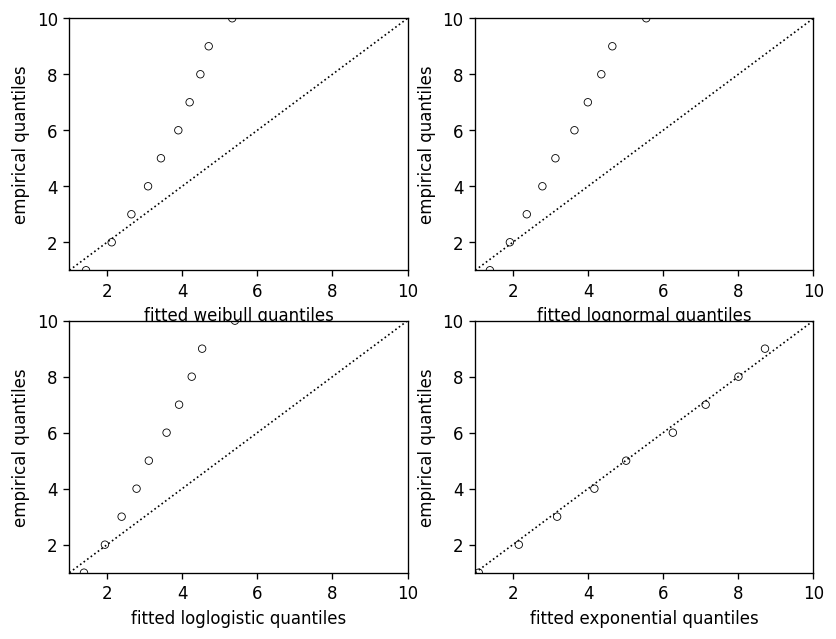

In [ ]:
surv_df10 = surv_df[surv_df["dia_len"]!= 1]
surv_df10["timeToCR"] = surv_df10["timeToCR"] - 1
T = surv_df10["timeToCR"]
E = surv_df10["CR"]
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)
AIC_ = []
BIC_ = []
models = []
Names_ = ["Weibull","LogNormal","LogLogistic","Exponential"]
for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(T, E)
    qq_plot(model, ax=axes[i])
    AIC_.append(model.AIC_)
    BIC_.append(model.BIC_)
    models.append(model)
AICs = pd.DataFrame({"Fitter":Names_,"AIC":AIC_,"BIC":BIC_}).round(2)
AICs

We can see that removing the first turn results in a better fit for the exponential model.

In [ ]:
exp = models[3]
exp.print_summary()

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 12275 total observations, 9719 right-censored observations>
   number of observations = 12275
number of events observed = 2556
           log-likelihood = -7675.24
               hypothesis = lambda_ != 0

---
          coef   se(coef)   coef lower 95%   coef upper 95%
lambda_   7.41       0.15             7.12             7.70

          cmp to     z      p   -log2(p)
lambda_     0.00 50.56 <0.005        inf
---
AIC = 15352.48

The main benefit of fitting a parametric model is that we can make predictions about the hazard rate passed the final time point:

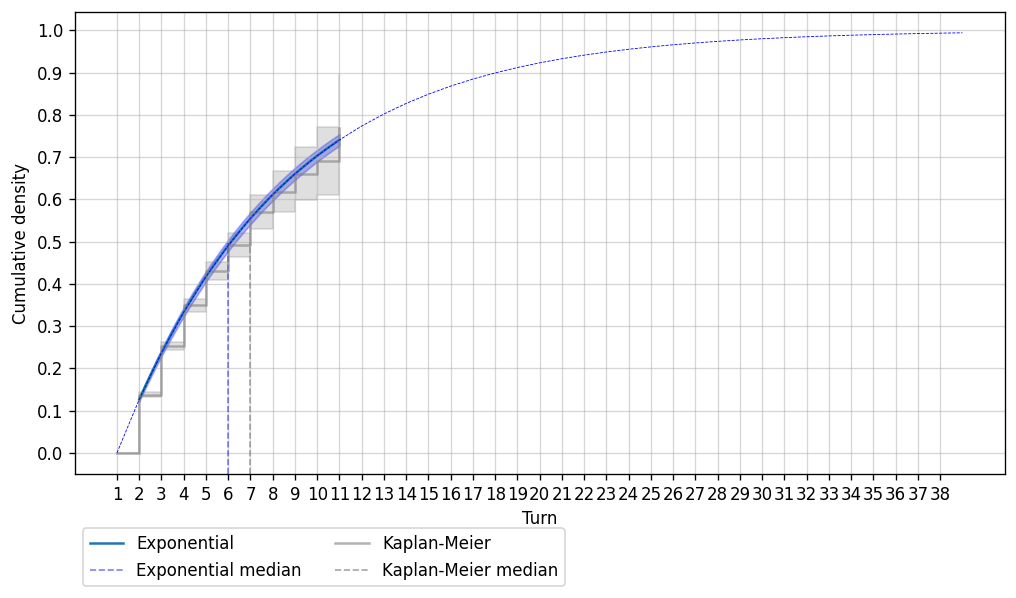

In [ ]:
# Assuming 'T' and 'E' are defined before this point

# Set the figure size before creating any subplots
%matplotlib inline
# Set the figure size before creating any subplots
plt.rcParams['figure.figsize'] = [10, 5]

mxt = 39
prd = get_cumulative_density(exp, max_time=mxt)

# New row to be added
new_row = {'Time': 0, 'Cumulative density': 0}
# Concatenate the new row to make it the first row
prd2 = pd.concat([pd.DataFrame([new_row]), prd]).reset_index(drop=True)

# Fit and plot Exponential
exp = ExponentialFitter()
exp.fit(T, event_observed=E, label="Exponential")
exp.cumulative_density_.plot()
lower_bound = exp.confidence_interval_cumulative_density_['Exponential_lower_0.95']
upper_bound = exp.confidence_interval_cumulative_density_['Exponential_upper_0.95']
# Fill between the confidence intervals
plt.fill_between(exp.cumulative_density_.index, lower_bound, upper_bound, alpha=0.3, color='blue')
# Add a dashed line at y > 0.5 and the x value closest to an integer
threshold = 0.5
plt.axvline(x=round(exp.median_survival_time_, 0), linestyle='--', color='blue', label=f'Exponential median', ymax=threshold, linewidth=1, alpha=0.5)

# Fit and plot Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label="Kaplan-Meier")
kmf.plot_cumulative_density(color="grey", alpha=0.6)
plt.axvline(x=kmf.median_survival_time_, linestyle='--', color='grey', label=f'Kaplan-Meier median', ymax=threshold, linewidth=1, alpha=0.7)

# Plot PRD with an extra point at (0, 0)
plt.plot(prd2['Time'], prd2['Cumulative density'], linestyle='--', color='blue', label='', linewidth = 0.5)

# Rest of the code remains unchanged
old_ticks = list(range(0, mxt-1))
new_ticks = list(range(1, mxt))
plt.xticks(old_ticks, new_ticks)
# Set custom ticks on the y-axis at 0.1 intervals
custom_ticks_y = np.arange(0, 1.1, 0.1)
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=2)
plt.yticks(custom_ticks_y)
#plt.legend(loc='right', bbox_to_anchor=(1.45, 0.9))
plt.xlabel('Turn')
plt.ylabel('Cumulative density')
plt.grid(True, alpha=0.5)
plt.show()



In [ ]:
turn_at_50 = prd[prd["Cumulative density"] >= 0.5].Time.min()
turn_at_95 = prd[prd["Cumulative density"] >= 0.95].Time.min()
turn_at_99 = prd[prd["Cumulative density"] >= 0.99].Time.min()
print(f"At time {turn_at_50}, 50% of dialogues are estimated to experience a repair.")
print(f"At time {turn_at_95}, 95% of dialogues are estimated to experience a repair.")
print(f"At time {turn_at_99}, 99% of dialogues are estimated to experience a repair.")

At time 6, 50% of dialogues are estimated to experience a repair.
At time 23, 95% of dialogues are estimated to experience a repair.
At time 35, 99% of dialogues are estimated to experience a repair.


In [ ]:
kmf_median = kmf.median_survival_time_ + 1
exp_median = exp.median_survival_time_ + 1
print(f"Kaplan Meier median survival {kmf_median}")
print(f"Exponential median survival {exp_median:.2f}")

Kaplan Meier median survival 7.0
Exponential median survival 6.14


We can observe that the likelihood of repair is predicted to gradually approach 1 (99% at t=35). However, the short time lengths make this uncertain (e.g., a drop in likelihood at turns > 11).  

## 4.3 Comparing subreddit hazard rates

The below graph shows an estimated exponential model for each of the 27 subreddits (converted into a cumulative density), with the Kaplan Meier curve for reference.

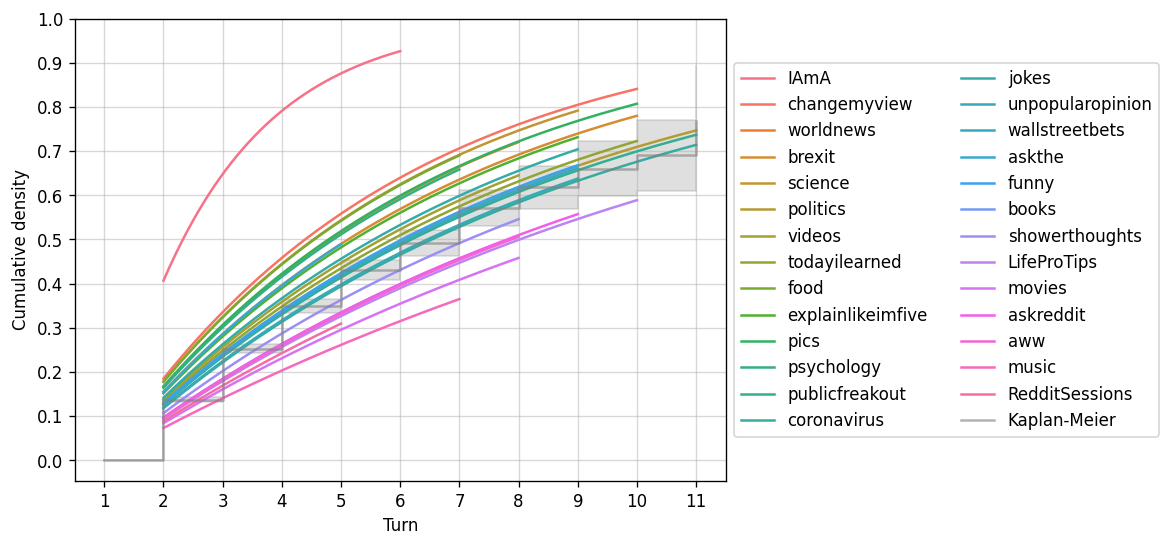

In [ ]:
sub_df = surv_df10.groupby("sub").agg({"CR":"mean"}).reset_index()
sub_df = sub_df.sort_values("CR",ascending=False)
sub_order = sub_df["sub"].to_list()
exp = ExponentialFitter()
plt.figure(figsize=(7, 5))
surv_df
# Initialize ax outside the loop
ax = plt.subplot(111)
colors = sns.color_palette('husl', len(surv_df10["sub"].unique()))

for i, sub in enumerate(sub_order):
    T_temp = surv_df10[surv_df10["sub"] == sub].timeToCR
    E_temp = surv_df10[surv_df10["sub"] == sub].CR
    exp.fit(T_temp, E_temp, label=sub)
    exp.cumulative_density_.plot(ax=ax, color = colors[i])
kmf = KaplanMeierFitter()
kmf.fit(T,E, label = "Kaplan-Meier")
kmf.plot_cumulative_density(ax=ax, loc=slice(0, 20),color="grey", alpha=0.6)

old_ticks = list(range(0,11))
new_ticks = list(range(1,12))
plt.xticks(old_ticks, new_ticks)
# Set custom ticks on the y-axis at 0.1 intervals
custom_ticks_y = np.arange(0, 1.1, 0.1)
plt.yticks(custom_ticks_y)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.xlabel('Turn')
plt.ylabel('Cumulative density')
plt.grid(True, alpha=0.5)
plt.show()

This table shows the median survival times for each subreddit.

In [ ]:
kmf = KaplanMeierFitter()
exp = ExponentialFitter()
mst = []
mst_e = []
for i, sub in enumerate(sub_order):
    T_temp = surv_df10[surv_df10["sub"] == sub].timeToCR
    E_temp = surv_df10[surv_df10["sub"] == sub].CR
    kmf.fit(T_temp, E_temp, label=sub)
    exp.fit(T_temp, E_temp, label=sub)
    mst.append(kmf.median_survival_time_)
    mst_e.append(exp.median_survival_time_)
pd.DataFrame({"sub":sub_order, "median survival":mst,"median survival estimate":mst_e}).round().sort_values("median survival")

,sub,median survival,median survival estimate
0,IAmA,1.0,1.0
1,changemyview,4.0,3.0
2,worldnews,4.0,4.0
9,explainlikeimfive,4.0,4.0
3,brexit,5.0,4.0
23,askreddit,5.0,7.0
6,videos,5.0,5.0
20,showerthoughts,5.0,6.0
14,jokes,5.0,5.0
12,publicfreakout,5.0,5.0


So we can see the exponential fitter works well to estimate a univariate model. It estimates a slightly lower median survival time (6 turns) than the non-parametric model, however we can see that the kmf-estimate between turn 6 and 7 is just below 0.5.

The next step is to use Cox regression to estimate different effects of covariates.

## 4.4 Cox regression model

First check, using cross validation, whether a cox proportional hazards model would be appropriate compared to other survival regressions:

In [ ]:
surv_df11 = surv_df10[["timeToCR","CR","aut","wc","neg","pos"]]
#create the three models we'd like to compare.
aaf = AalenAdditiveFitter()
weib = WeibullAFTFitter()
cph = CoxPHFitter()
# Cox model best for predicting survival times according to the concordance
mean_cox = np.mean(k_fold_cross_validation(cph, surv_df11, duration_col='timeToCR', event_col='CR', scoring_method="concordance_index"))
mean_AalenAdditive = np.mean(k_fold_cross_validation(weib, surv_df11, duration_col='timeToCR', event_col='CR', scoring_method="concordance_index"))
mean_Weibull = np.mean(k_fold_cross_validation(aaf, surv_df11, duration_col='timeToCR', event_col='CR', scoring_method="concordance_index"))
print(f"Cox PH model Concordance-index mean = {mean_cox:.2f}")
print(f"Aalen Additive model Concordance-index mean = {mean_AalenAdditive:.2f}")
print(f"Weibull model Concordance-index mean = {mean_Weibull:.2f}")


Cox PH model Concordance-index mean = 0.63
Aalen Additive model Concordance-index mean = 0.57
Weibull model Concordance-index mean = 0.60


This Concordance-index is highest for the Cox model. We now use backwards stepwise elimination to determine next model.

NOTE: The second equation removes wc as it consistently fails the proportional hazards test.

In [ ]:
formulas = ["aut + neg + pos + wc + neg:pos",
            "aut + neg + pos + neg:pos",
            "aut + neg + pos + wc",
            "aut + neg + pos",
            "aut"]
def run_regression(f):
  try:
    m = CoxPHFitter().fit(surv_df10,duration_col="timeToCR", event_col="CR", strata = "sub", cluster_col = "id_conv",formula = f)
    return m
  except:
    print(f"failed for: {f}")
models = [run_regression(f) for f in formulas]

partial_AIC_(surv_df10, model_names = formulas,models = models)

,Model,Partial AIC
1,aut + neg + pos + neg:pos,28851.269
3,aut + neg + pos,28851.528
0,aut + neg + pos + wc + neg:pos,28851.998
2,aut + neg + pos + wc,28852.201
4,aut,29196.185


It looks like the four more complex models are nearly identical. We remove word count as it fails the proportional hazards and go with the simpler model.

Below checks to see if a more simple strata (desirable for power) would lead to more clear results. We see that aut and neg fail the proportional hazards under this model, meaning baseline hazard rates are good.

In [ ]:
f = "aut + neg + pos"
mi = CoxPHFitter().fit(surv_df10, duration_col="timeToCR", event_col="CR", strata = "sub", cluster_col="id_conv", formula = f)
mi.check_assumptions(surv_df10)

Proportional hazard assumption looks okay.


[]

Adding in stratification (i.e., where each subreddit has a different baseline hazard rate) leads to the proportional hazards assumption being met. We use this as the final model.

4.4.1 Results

In [ ]:
f = "aut + neg + pos"
m = CoxPHFitter().fit(surv_df10, duration_col="timeToCR", event_col="CR", strata = "sub", cluster_col="id_conv", formula = f)
m.print_summary()

model,lifelines.CoxPHFitter
duration col,'timeToCR'
event col,'CR'
cluster col,'id_conv'
robust variance,True
strata,sub
baseline estimation,breslow
number of observations,12275
number of events observed,2556
partial log-likelihood,-14422.76
time fit was run,2024-02-17 14:40:31 UTC


Assumptions look good - the residuals are rougly distributed across a horizontal line and the proportional hazards test is met:

In [ ]:
m.check_assumptions(surv_df10, show_plots=True)